In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle
from datetime import timedelta as timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import *
# import datetime as dt

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


# Load the Synthetic Profiles

## Flatten the Measured and synthetic data

In [26]:
id = 1186

# Load in the measured data
measured_data = pd.read_csv("CSV_Exclude/Measured_Profiles_Missing_days_replaced_sorted.csv")
measured_data['date'] = pd.to_datetime(measured_data['date'])
measured_data['date'] = measured_data['date'].apply(lambda x: x.date())
measured_data.set_index(['ProfileID', 'date'], inplace = True)
measured_data.drop(['ProfileID.1'], axis = 1, inplace = True)

# Flatten the  measured data
temp = measured_data.copy()
flat_meas_df = temp.stack().reset_index()
flat_meas_df.columns = [ 'ProfileID', 'date', 'hour', 'A']
flat_meas_df['kWh'] = flat_meas_df['A']*230/1000
flat_meas_df.set_index(['ProfileID'], inplace = True)
flat_meas_df

# Load in the synthetic data
synthetic_data = pd.read_csv("Synthetic_Profiles_with_Dates.csv")
synthetic_data.set_index(['ProfileID', 'date'], inplace = True)

# Flatten the synthetic data
temp = synthetic_data.copy()
flat_synth_df = temp.stack().reset_index()
flat_synth_df.columns = [ 'ProfileID', 'date', 'hour', 'A']
flat_synth_df['kWh'] = flat_synth_df['A']*230/1000
flat_synth_df.set_index(['ProfileID'], inplace = True)
flat_synth_df

,date,hour,A,kWh
ProfileID,,,,
1,1994-01-01,0,1.492697,0.343320
1,1994-01-01,1,1.518544,0.349265
1,1994-01-01,2,1.586362,0.364863
1,1994-01-01,3,1.720328,0.395675
1,1994-01-01,4,1.912825,0.439950
...,...,...,...,...
12029036,1994-12-31,19,4.980843,1.145594
12029036,1994-12-31,20,5.331693,1.226289
12029036,1994-12-31,21,4.586161,1.054817


# Functions that calculate the PV Utilization and Export

In [27]:
SAM_df_org = pd.read_csv('SAM/SAM_Stellenbosch.csv')
SAM_df_org['date'] = str(2022 ) + " " +  SAM_df_org['Time stamp']
SAM_df_org['date'] = pd.to_datetime(SAM_df_org['date'])
SAM_df_org.drop(['Time stamp'], axis = 1, inplace = True)
SAM_df_org = SAM_df_org[['date','System power generated | (kW)']]
def calc_PV_Percentages_Synth(SAM_df_org,flat_synth_df):
    df1 = flat_synth_df.copy()
    df1.reset_index(inplace = True)
    df1.drop(['ProfileID'], axis = 1,inplace = True)
    
    SAM_df = SAM_df_org.copy()

    for n in np.arange(0.001, 1, 0.001):
        SAM_df['DC Output'] = SAM_df['System power generated | (kW)']*n
        SAM_df['Load'] = df1['kWh']
        SAM_df['Result'] = SAM_df['Load'] - SAM_df['DC Output'] 
        SAM_df['Not Supplied'] = np.where(SAM_df['Result'] < 0, 0,SAM_df['Result'])
        SAM_df['Supplied'] = SAM_df['Load'] - SAM_df['Not Supplied']
        SAM_df['Excess'] = SAM_df['Result'].apply(lambda x: x if x < 0 else 0)

        Total_Excess = -1*SAM_df['Excess'].sum()
        Not_Supplied = SAM_df['Not Supplied'].sum()
        Supplied = SAM_df['Supplied'].sum()
        Excess_perc = Total_Excess/SAM_df['DC Output'].sum()*100
        Supplied_perc = Supplied/SAM_df['Load'].sum()*100

        if Excess_perc > 5.0:
            Supplied_perc_final = Supplied_perc
            Excess_perc_final = Excess_perc
            Total_Excess_final = Total_Excess
            Supplied_final = Supplied
            n_final = n
            return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

In [28]:
MEAS_df_org =  pd.read_csv('SAM/SAM_Stellenbosch.csv')
MEAS_df_org['date'] = str(2022 ) + " " +  MEAS_df_org['Time stamp']
MEAS_df_org['date'] = pd.to_datetime(MEAS_df_org['date'])
MEAS_df_org.drop(['Time stamp'], axis = 1, inplace = True)
MEAS_df_org = MEAS_df_org[['date','System power generated | (kW)']]
def calc_PV_Percentages_meas(MEAS_df_org,flat_meas_df, n):
    df2 = flat_meas_df
    df2.reset_index(inplace = True)
    df2.drop(['ProfileID'], axis = 1,inplace = True)

    MEAS_df = MEAS_df_org.copy()

    MEAS_df['DC Output'] = MEAS_df['System power generated | (kW)']*n
    MEAS_df['Load'] = df2['kWh']
    MEAS_df['Result'] = MEAS_df['Load'] - MEAS_df['DC Output'] 
    MEAS_df['Not Supplied'] = np.where(MEAS_df['Result'] < 0, 0,MEAS_df['Result'])
    MEAS_df['Supplied'] = MEAS_df['Load'] - MEAS_df['Not Supplied']
    MEAS_df['Excess'] = MEAS_df['Result'].apply(lambda x: x if x < 0 else 0)

    Total_Excess2 = -1*MEAS_df['Excess'].sum()
    Not_Supplied2 = MEAS_df['Not Supplied'].sum()
    Supplied2 = MEAS_df['Supplied'].sum()
    Excess_perc2 = Total_Excess2/MEAS_df['DC Output'].sum()*100
    Supplied_perc2 = Supplied2/MEAS_df['Load'].sum()*100

    return Excess_perc2, Total_Excess2, Supplied_perc2, Supplied2

# Store the PV Utilization and Export Results

In [29]:
cols = pd.MultiIndex.from_tuples([('Measured', 'n_factor'),
                                ('Measured', 'Percentage Excess'),
                                ('Measured', 'Excess'),
                                ("Measured", "Percentage Supplied"),
                                ("Measured", "Supplied"),  
                                ("Synthetic", "Percentage Excess"),
                                ('Synthetic', 'Excess'),
                                ("Synthetic", "Percentage Supplied"),
                                ("Synthetic", "Supplied")
                                ])
index = flat_synth_df.index.unique()
PV_Results_df2 = pd.DataFrame(index = index, columns=cols)
PV_Results_df2

Measured                                                        \
          n_factor Percentage Excess Excess Percentage Supplied Supplied   
ProfileID                                                                  
1              NaN               NaN    NaN                 NaN      NaN   
5              NaN               NaN    NaN                 NaN      NaN   
6              NaN               NaN    NaN                 NaN      NaN   
10             NaN               NaN    NaN                 NaN      NaN   
11             NaN               NaN    NaN                 NaN      NaN   
...            ...               ...    ...                 ...      ...   
12029019       NaN               NaN    NaN                 NaN      NaN   
12029023       NaN               NaN    NaN                 NaN      NaN   
12029027       NaN               NaN    NaN                 NaN      NaN   
12029032       NaN               NaN    NaN                 NaN      NaN   
12029036       NaN               NaN    NaN                 NaN      NaN   

                  Synthetic                                      
          Percentage Excess Excess Percentage Supplied Supplied  
ProfileID                                                        
1                       NaN    NaN                 NaN      NaN  
5                       NaN    NaN                 NaN      NaN  
6                       NaN    NaN                 NaN      NaN  
10                      NaN    NaN                 NaN      NaN  
11                      NaN    NaN                 NaN      NaN  
...                     ...    ...                 ...      ...  
12029019                NaN    NaN                 NaN      NaN  
12029023                NaN    NaN                 NaN      NaN  
12029027                NaN    NaN                 NaN      NaN  
12029032                NaN    NaN                 NaN      NaN  
12029036                NaN    NaN                 NaN      NaN  

[8360 rows x 9 columns]

In [31]:
for id in tqdm(index): 

    Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final = calc_PV_Percentages_Synth(SAM_df_org,flat_synth_df.loc[id])
    Excess_perc_final2,Total_Excess_final2, Supplied_perc_final2, Supplied_final2 = calc_PV_Percentages_meas(MEAS_df_org,flat_meas_df.loc[id],n_final)
    

    data = [n_final,Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final,Excess_perc_final2,Total_Excess_final2, Supplied_perc_final2, Supplied_final2]
    PV_Results_df2.loc[id] = data

<ipython-input-31-f6435bcb11de>:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8360 [00:00<?, ?it/s]

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\U

# Perform the PV system sizing and determine the % Utilization and % Export 

In [33]:
cols = pd.MultiIndex.from_tuples([('Measured', 'n_factor'),
                                ('Measured', 'Percentage Excess'),
                                ('Measured', 'Excess'),
                                ("Measured", "Percentage Supplied"),
                                ("Measured", "Supplied"),  
                                ('Synthetic', 'n_factor'),
                                ("Synthetic", "Percentage Excess"),
                                ('Synthetic', 'Excess'),
                                ("Synthetic", "Percentage Supplied"),
                                ("Synthetic", "Supplied")
                                ])
index = np.arange(0.001, 3, 0.001)
# index = flat_synth_df.index.unique()
Results_df = pd.DataFrame(index = index, columns=cols)
Results_df.head(1)

Measured                                                        \
      n_factor Percentage Excess Excess Percentage Supplied Supplied   
0.001      NaN               NaN    NaN                 NaN      NaN   

      Synthetic                                                        
       n_factor Percentage Excess Excess Percentage Supplied Supplied  
0.001       NaN               NaN    NaN                 NaN      NaN

In [34]:
SAM_df_org = pd.read_csv('SAM/SAM_Stellenbosch.csv')
SAM_df_org['date'] = str(2022 ) + " " +  SAM_df_org['Time stamp']
SAM_df_org['date'] = pd.to_datetime(SAM_df_org['date'])
SAM_df_org.drop(['Time stamp'], axis = 1, inplace = True)
SAM_df_org = SAM_df_org[['date','System power generated | (kW)']]
# def calc_PV_Percentages_Synth(SAM_df_org,flat_synth_df):
MEAS_df_org =  pd.read_csv('SAM/SAM_Stellenbosch.csv')
MEAS_df_org['date'] = str(2022 ) + " " +  MEAS_df_org['Time stamp']
MEAS_df_org['date'] = pd.to_datetime(MEAS_df_org['date'])
MEAS_df_org.drop(['Time stamp'], axis = 1, inplace = True)
MEAS_df_org = MEAS_df_org[['date','System power generated | (kW)']]

In [35]:
id = 12029036

df1 = flat_synth_df.copy()
df1 = df1.loc[id]
df1.reset_index(inplace = True)
df1.drop(['ProfileID'], axis = 1,inplace = True)

df2 = flat_meas_df.copy()
df2 = df2.loc[id]
df2.reset_index(inplace = True)
df2.drop(['ProfileID'], axis = 1,inplace = True)

In [36]:
SAM_df = SAM_df_org.copy()
MEAS_df = MEAS_df_org.copy()
# Store all the values

for n in tqdm(np.arange(0.001, 3, 0.001)):
    SAM_df['DC Output'] = SAM_df['System power generated | (kW)']*n
    SAM_df['Load'] = df1['kWh']
    SAM_df['Result'] = SAM_df['Load'] - SAM_df['DC Output'] 
    SAM_df['Not Supplied'] = np.where(SAM_df['Result'] < 0, 0,SAM_df['Result'])
    SAM_df['Supplied'] = SAM_df['Load'] - SAM_df['Not Supplied']
    SAM_df['Excess'] = SAM_df['Result'].apply(lambda x: x if x < 0 else 0)

    MEAS_df['DC Output'] = MEAS_df['System power generated | (kW)']*n
    MEAS_df['Load'] = df2['kWh']
    MEAS_df['Result'] = MEAS_df['Load'] - MEAS_df['DC Output'] 
    MEAS_df['Not Supplied'] = np.where(MEAS_df['Result'] < 0, 0,MEAS_df['Result'])
    MEAS_df['Supplied'] = MEAS_df['Load'] - MEAS_df['Not Supplied']
    MEAS_df['Excess'] = MEAS_df['Result'].apply(lambda x: x if x < 0 else 0)

    Total_Excess_synth = -1*SAM_df['Excess'].sum()
    Not_Supplied_synth = SAM_df['Not Supplied'].sum()
    Supplied_synth = SAM_df['Supplied'].sum()
    Excess_perc_synth = Total_Excess_synth/SAM_df['DC Output'].sum()*100
    Supplied_perc_synth = Supplied_synth/SAM_df['Load'].sum()*100
    
    Total_Excess_meas = -1*MEAS_df['Excess'].sum()
    Not_Supplied_meas = MEAS_df['Not Supplied'].sum()
    Supplied_meas = MEAS_df['Supplied'].sum()
    Excess_perc_meas = Total_Excess_meas/MEAS_df['DC Output'].sum()*100
    Supplied_perc_meas = Supplied_meas/MEAS_df['Load'].sum()*100

    data = [n, Excess_perc_synth, Total_Excess_synth, Supplied_perc_synth, Supplied_synth, n, Excess_perc_meas, Total_Excess_meas, Supplied_perc_meas, Supplied_meas]    
    Results_df.loc[n] = data
    # return Excess_perc_final,Total_Excess_final, Supplied_perc_final, Supplied_final, n_final

<ipython-input-36-a59bd8ea84e4>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/2999 [00:00<?, ?it/s]

## Create line chart of the supplied vs. excess power generated

[(0.0, 0.5)]

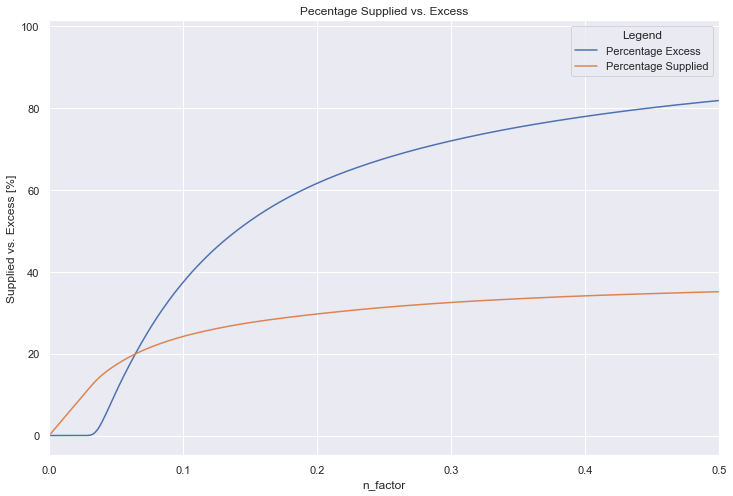

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

temp = Results_df['Measured'][['n_factor', 'Percentage Excess', 'Percentage Supplied']]
temp = temp.apply(pd.to_numeric, errors='coerce')
# convert to long (tidy) form
tempm = temp.melt('n_factor', var_name='Legend', value_name='Supplied_vs_Excess')
# convert to long (tidy) form
# dfm = df.melt('X_Axis', var_name='cols', value_name='vals')

g = sns.lineplot(data = temp, x = tempm['n_factor'], y = tempm['Supplied_vs_Excess'], hue = tempm['Legend'])
#add overall title to replot
g.set_ylabel("Supplied vs. Excess [%]")
g.set(title = 'Pecentage Supplied vs. Excess')
sns.set(rc={"figure.figsize":(12, 8)}) #width=3, #height=4
g.set(xlim = (0,0.5))

# Boxplots: % Utilization, % Export of Actual and Synth

In [39]:
temp = PV_Results_df2

In [40]:
temp['Supplied Error'] = temp['Measured']['Percentage Supplied'] - temp['Synthetic']['Percentage Supplied']#/temp['Measured']['Supplied']
temp['Excess Error'] = temp['Measured']['Percentage Excess'] - temp['Synthetic']['Percentage Excess']#/temp['Measured']['Excess']

In [41]:
temp1 = temp[['Supplied Error', 'Excess Error']]
temp1 = temp1.droplevel(1, axis = 1)

[Text(0, 0.5, 'Percentage Error [%]')]

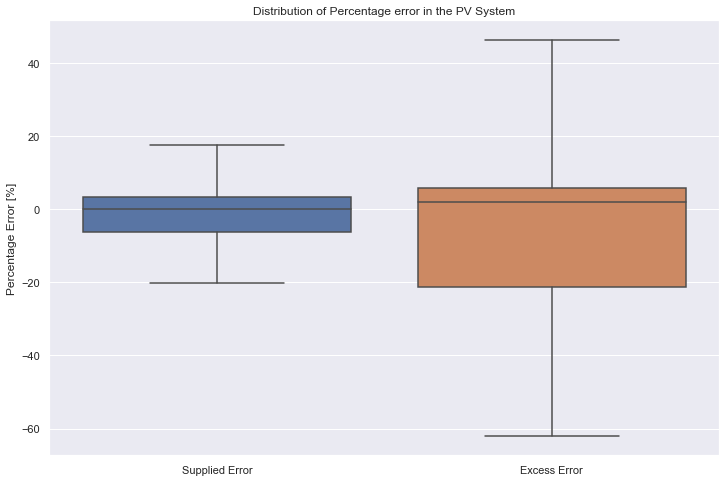

In [42]:
g = sns.boxplot(data = temp1, showfliers = False)
g.set(title = "Distribution of Percentage error in the PV System")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4
# g.set_xticks([0,1])
# g.show(legend = True)
g.set(ylabel =("Percentage Error [%]"))
# g.set_xticklabels(['Under', 'Over'])

In [79]:
# PV_Results_df2.drop(['Supplied Error','Excess Error','Synthetic Utilisation', 'Actual Utilisation', 'Synthetic Exported', 'Actual Exported'], axis = 1, inplace = True)

In [105]:
PV_Results_df2.columns.levels[1]

Index(['Excess', 'Percentage Excess', 'Percentage Supplied', 'Supplied',
       'n_factor', ''],
      dtype='object')

In [124]:
temporary = PV_Results_df2.copy()
temporary.columns = temporary.columns.values
temporary.columns = pd.MultiIndex.from_tuples(temporary.rename(columns={('Measured', 'Percentage Excess'): ('Measured', 'M Excess'), ('Measured', 'Percentage Supplied'): ('Measured', 'M Supplied'),
                                                                            ('Synthetic', 'Percentage Excess'): ('Synthetic', 'S Excess'), ('Synthetic', 'Percentage Supplied'): ('Synthetic', 'S Supplied')}))
temporary = temporary.drop(['n_factor', 'Excess', 'Supplied'], axis = 1, level = 1)
d = dict(zip(temporary.columns.levels[1], ['','Exported','Utilisation','Exported','Utilisation']))
temporary = temporary.rename(columns=d, level=1)

# # temporary.columns = temporary.columns.set_levels(['Exported Act','Utilisation Act','Exported Synth','Utilisation Synth'],level=1)
temporary = pd.melt(temporary)
temporary.at[temporary['variable_0'] == 'Measured',['variable_0']] = 'Actual'
# temporary = temporary.unstack().reset_index()#.drop('level_0', axis=1)
# temporary = temporary.stack().reset_index()
temporary.columns = ['Legend', '', 'Percentage [%]']
temporary

# temporary['Synthetic Utilisation'] = PV_Results_df2['Synthetic']['Percentage Supplied']
# temporary['Actual Utilisation'] = PV_Results_df2['Measured']['Percentage Supplied']
# temporary['Synthetic Exported'] = PV_Results_df2['Synthetic']['Percentage Excess']
# temporary['Actual Exported'] = PV_Results_df2['Measured']['Percentage Excess']

,Legend,,Percentage [%]
0,Actual,Exported,5.398119
1,Actual,Exported,5.09155
2,Actual,Exported,5.136964
3,Actual,Exported,5.005977
4,Actual,Exported,5.113067
...,...,...,...
33435,Synthetic,Utilisation,21.062695
33436,Synthetic,Utilisation,24.151619
33437,Synthetic,Utilisation,25.695051
33438,Synthetic,Utilisation,32.337027


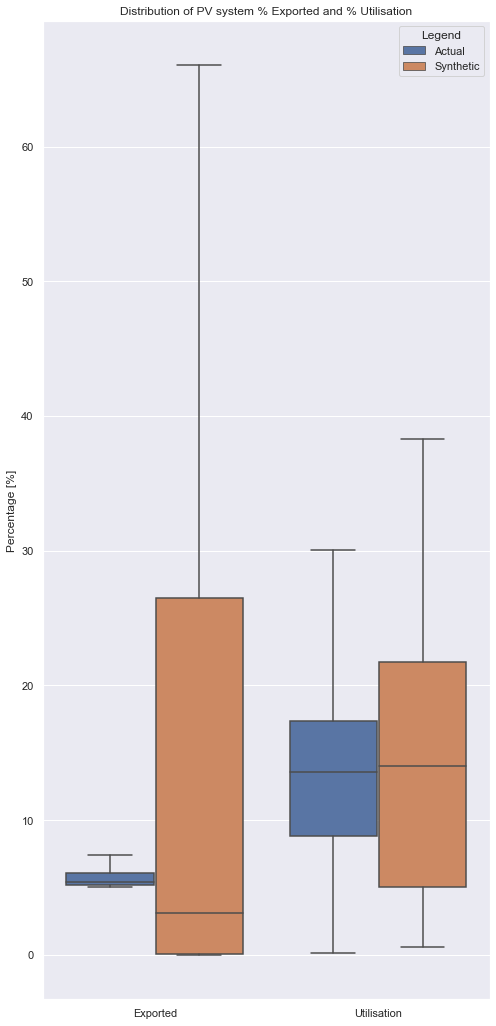

In [126]:
g = sns.boxplot(x = temporary[''],y = temporary['Percentage [%]'], hue = temporary['Legend'], showfliers = False)
g.set(title = "Distribution of PV system % Exported and % Utilisation")
sns.set(rc={"figure.figsize":(8,18)}) #width=3, #height=4
# g.set_xticks([0,1])
# g.show(legend = True)
# g.set(ylabel =("Percentage Error [%]"))